<a href="https://colab.research.google.com/github/Tum2001/ksa-project/blob/main/Copy_of_Randomforest_Crop_and_Land_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Model for Crop Type and Land Classification

> Using RandomForest Classifier for crop type mapping with data from Google Earth Engine.

- toc: true
- badges: true
- author: Drew Bollinger, Zhuang-Fang Yi, Alex Mandel
- comments: false
- hide: false
- sticky_rank: 5


This notebook teaches you how to read satellite imagery (Sentinal-2) from **Google Earth Engine** and use it for crop type mapping with a RandomForest Classifier. 

We will use data created by SERVIR East Africa, RCMRD, and FEWSNET. Demonstrating how to train a RandomForest classifier over Trans Nzoia county, Kenya.


>Note: If you would like to replicate the workflow with the same data on your local machine, please download the data from our shared [Google Drive folder](https://drive.google.com/drive/folders/1jM2mBsJ81QfmyaKZNeXSTyi_IOVr_3Vs?usp=sharing).




### Setup Notebook

In [1]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install folium earthengine-api
%pip install scikit-learn
%pip install treeinterpreter

     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 6.3 MB 5.5 MB/s 
     |████████████████████████████████| 15.4 MB 38.7 MB/s 
     |████████████████████████████████| 130 kB 49.6 MB/s 


In [2]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

### Connect Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [9]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/MyDrive/Colab notebooks"

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Label data preparation

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over.



In [14]:
# read in training data polygons that created as geojson from a shared directory
training_data = '//content/drive/MyDrive/Colab notebooks/training_data.geojson'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.90750 1.08934, 34.90753 1.0..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


## Reading imagery from Google Earth Engine (GEE)

For this example we will be using Google Earth Engine to select and filter Satellite imagery that we will classify with the training data.

### Connect to GEE

In [15]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api #earth-engine Python API

# Athenticate to your GEE account. 
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=BJ6OnOuC9Ob1AxKKJRTTq4QYWw3VC-CwaS6zmz5LlWY&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjLt1briGCaYp-t3h9CZwAL37k4QvpC7GbULG73fI7plsdz9kOoIZY

Successfully saved authorization token.


In [16]:
# Earth Engine Python API
import ee 
ee.Initialize()

### Search GEE Data

We will now search for Sentinel 2 imagery, a multispectral satellite with ~10m resolution and repeat coverage every 5 days.

Filters will include selecting bands, a date range, and only imagery within a defined Area of Interest (AOI).

In [17]:
# From GEE
#training_vectors.total_bounds.tolist()
aoi = ee.Geometry.Rectangle(training_vectors.total_bounds.tolist())
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate('2019-05-02', '2019-05-03')\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

sentinel_mosaic.getInfo()

COPERNICUS/S2/20190502T074621_20190502T080204_T36NXF
COPERNICUS/S2/20190502T074621_20190502T080204_T36NXG
COPERNICUS/S2/20190502T074621_20190502T080204_T36NYF
COPERNICUS/S2/20190502T074621_20190502T080204_T36NYG


{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B2'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B3'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B4'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B8'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B11'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 

In [18]:
# To make a map we first need some helper functions

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz) 
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [19]:
s2_vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

Mapdisplay(center=[center.y, center.x],
           dicc={'S2':sentinel_mosaic.getMapId(s2_vis_params),
                 'TrainingData':training_vectors}, 
           zoom_start=12)


### Exporting Image

Since our analysis method in this example will happen outside of Google Earth Engine we will be exporting the search results to a Cloud Optimized Geotiff, a common GIS format for rasters. This will highlight that you can get imagery from any data source for this type of analysis.

In [20]:
# We will save it to Google Drive for later reuse
raster_name = op.join(my_root_dir,'sentinel_mosaic-Trans_Nzoia')

In [21]:
# Export the image, specifying scale and region.
# Warning, This specific export takes at least 1 hour, and 700+ MB
# There may be a bug here, not sure GEE export can write to a folder beyond depth 1 in a google drive
task = ee.batch.Export.image.toDrive(**{
    'image': sentinel_mosaic,
    'description': 'Trans_nzoia_2019_05_02',
    'folder': my_root_dir,
    'fileNamePrefix': raster_name,
    'scale': 10,
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

# This task will run in the background even if you close this notebook.
# You can also check on the status of the task through the Javascript GEE interface
# https://code.earthengine.google.com
task.start()



In [22]:
# If you want to keep track of the export you can run this code
# However if run this, you will need to wait for it to finish before running additional code

import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id: WFCWUA3KEUQ4YD3GEJ2EURR6).
Polling for task (id

KeyboardInterrupt: ignored

In [23]:
# Reference the raster on disk.
raster_path = op.join(my_root_dir, raster_name)
raster_file = ".".join([raster_path, "tif"])
# Alternate reference already prepared file on Google Drive, uncomment next line to use
#raster_file = '/content/drive/Shared drives/servir-sat-ml/data/Trans_nzoia_2019_05-02.tif'

print(raster_file)

/content/drive/MyDrive/Colab notebooks/sentinel_mosaic-Trans_Nzoia.tif


## Model training

Now we're going to work on training a model to identify classes of land use based on the training data and the satellite imagery.

### Prepare Data

First we will need to do some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery.

In [24]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.name)
classes

array(['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize',
       'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody'], dtype=object)

In [25]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict                  

{'Built': 0,
 'Cloud': 1,
 'Fallow': 2,
 'Forestland': 3,
 'Grassland': 4,
 'Maize': 5,
 'Shadow': 6,
 'Sugarcane': 7,
 'Sunflower': 8,
 'Waterbody': 9}

This section loops through the training classes and their polygons reading the imagery raster extracting values.

In [28]:
# raster information

##If you want to read the data directly from the shared folder, uncomment the following line.
raster_file = '/content/drive/MyDrive/Colab notebooks/Trans_nzoia_2019_05-02.tif'


# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [29]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((160461, 6), (160461,))

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [30]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(160461, 8)

Now were going to split 20% of the data to reserve for testing  the quality of the trained model.

In [31]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [32]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.00046882325363338024,
 1: 0.001597444089456869,
 2: 0.0004928536224741252,
 3: 1.970093973482535e-05,
 4: 0.000819000819000819,
 5: 1.5704257424187697e-05,
 6: 0.0002473410833539451,
 7: 0.0002824858757062147,
 8: 0.05263157894736842,
 9: 0.003115264797507788}

### Train RandomForest

In [33]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    verbose=1,
    random_state=0)


In [34]:
# fit the model to the data (training)
clf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.2s finished


RandomForestClassifier(class_weight={0: 0.00046882325363338024,
                                     1: 0.001597444089456869,
                                     2: 0.0004928536224741252,
                                     3: 1.970093973482535e-05,
                                     4: 0.000819000819000819,
                                     5: 1.5704257424187697e-05,
                                     6: 0.0002473410833539451,
                                     7: 0.0002824858757062147,
                                     8: 0.05263157894736842,
                                     9: 0.003115264797507788},
                       max_depth=6, n_estimators=200, n_jobs=-1, random_state=0,
                       verbose=1)

In [35]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


In [36]:
# (optional) save the trained model as python pickle file
model_name = op.join(my_root_dir,'random_forest.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile)

### Assess the Model

A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

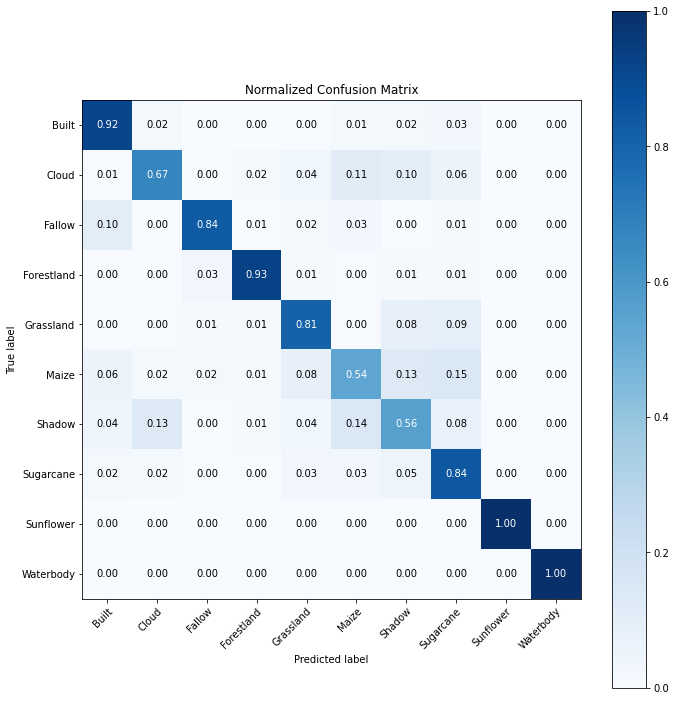

In [37]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

You can see the most often confused classes are Shadows with Clouds, Maize with Shadows, and Maize with Sugarcane.

In [38]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [39]:
# plot the contributions
band_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDWI']

gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
gdf.style.background_gradient(cmap='viridis')

,Built,Cloud,Fallow,Forestland,Grassland,Maize,Shadow,Sugarcane,Sunflower,Waterbody
Blue,-0.747125,-0.441951,-2.735175,5.982684,-0.463664,0.343633,-0.159056,-0.434804,-0.125558,-1.218985
Green,-1.049661,0.031668,-1.754779,3.092077,-0.274180,1.329185,0.553709,-0.280658,-0.755053,-0.892308
Red,-1.922405,-0.675401,0.627513,3.043718,0.157636,0.653037,-0.328419,-0.626324,-0.714323,-0.215032
NIR,0.060746,-0.257633,-3.147475,2.865785,-0.897522,1.357498,0.791979,0.511295,-1.031832,-0.252842
SWIR1,0.161948,0.013229,-1.003280,3.079717,-0.466298,0.883086,0.542066,0.284443,-0.899189,-2.595722
SWIR2,-0.735013,-0.464539,0.850399,2.670505,-0.112649,0.249625,-0.295466,-0.375152,-1.154408,-0.633303
NDVI,-0.855958,-0.186797,1.940422,3.344726,-0.919640,1.105372,-0.218740,-0.357435,-2.067999,-1.783952
NDWI,0.060485,0.033048,1.085565,2.957248,-1.147975,0.826286,0.639544,-0.499796,-2.156647,-1.797756


## Using the Model

### Generate predictions over the full image

Now that we've trained and tested the model over the existing data we can use the trained RandomForestClassifier `clf` over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [40]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, "classification.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 3, 2)
                img_ndwi = band_index(img_flat, 1, 3)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      |

### Make a Map


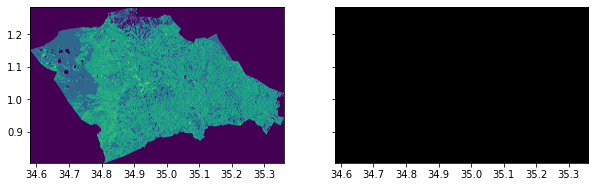

In [41]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/content/drive/MyDrive/Colab notebooks/classification.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)


You can also download and view the results in your favorite GIS application. There's a QGIS [style file](https://drive.google.com/file/d/1JMQWgqIediIRvEyNS3dwSkiELnC2HvVw/view?usp=sharing) in the Shared drive for visualizing.

In some cases imagery can often appear dark, you can check how well the data distribution spans the possible display values with a histogram. We applied a rescale function (just like we did when using Google Earth Engine earlier), in order to get a good RGB display of the imagery reflectance values.

This method can also be useful for exploring the distribution of classes in the model result.



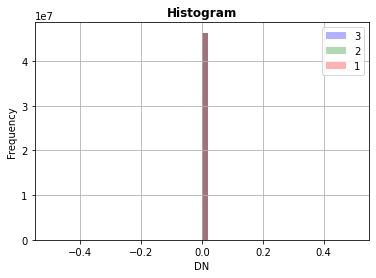

In [42]:
# Exploring why the imagery is so dark.
# Looks like it will need manual stretching to make a nice image
rasterio.plot.show_hist(s2, 
                   bins=50, 
                   histtype='stepfilled',
                   lw=0.0, 
                   stacked=False, 
                   alpha=0.3)